In [180]:
import utils

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from huggingface_hub import login
from transformers import LlamaTokenizer

pd.set_option('display.max_rows', 120)
pd.set_option('max_colwidth', 1000)

secrets = utils.jload('secrets.json')

In [153]:
generated_tasks = utils.jload('regen.json')
df = pd.DataFrame(generated_tasks)
print('Number of generated tasks:', len(df))

Number of generated tasks: 100


### Check `alt` Text

In [154]:
def get_alt_texts(html):
    alt_texts = []
    soup = BeautifulSoup(html, 'html.parser')
    img_tags = soup.find_all('img', alt=True)
    
    for img_tag in img_tags:
        alt_text = img_tag['alt'].strip()
        if alt_text:
            alt_texts.append(alt_text)
            
    return alt_texts
  
def get_avg_alt_word_count(alt_texts):
  total_words = 0
  total_strings = len(alt_texts)

  for string in alt_texts:
      words = string.split()
      total_words += len(words)

  if total_strings > 0:
      avg_word_count = total_words / total_strings
  else:
      avg_word_count = 0

  return int(avg_word_count)
  
# Check the word counts of alt texts in HTML outputs
df['alt_texts'] = df['output'].apply(get_alt_texts)
df['avg_alt_word_count'] = df['alt_texts'].apply(get_avg_alt_word_count)

alt_word_count_gte_5_df = df[df['avg_alt_word_count'] >= 5]
alt_word_count_lt_5_df = df[df['avg_alt_word_count'] < 5]

print('Number of alt texts with word count >= 5:', len(alt_word_count_gte_5_df))
print('Number of alt texts with word count < 5:', len(alt_word_count_lt_5_df))

Number of alt texts with word count >= 5: 0
Number of alt texts with word count < 5: 100


In [155]:
# new_generated_tasks_file_name = f'regen_new_{datetime.now().strftime("%Y%m%d%H%M%S")}.json'

# # Export data with alt texts having a word count < 5 to JSON
# alt_word_count_lt_5_df[[
#   'instruction', 
#   'output', 
#   'most_similar_instructions', 
#   'avg_similarity_score'
# ]].to_json(new_generated_tasks_file_name, orient='records')
# print(f'{new_generated_tasks_file_name} exported sucessfully!')

### Check Character Distribution

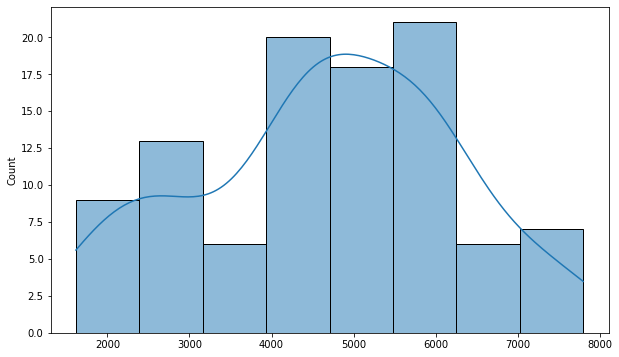

In [156]:
char_counts = df[['instruction', 'output']].applymap(len).sum(axis=1)

# Check the distribution of characters
plt.figure(figsize=(10,6))
sns.histplot(char_counts, kde=True)
plt.show()

### Check Token

In [181]:
login(token=secrets['HUGGING_FACE_TOKEN'])

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/admin/.cache/huggingface/token
Login successful


In [182]:
tokenizer = LlamaTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')

In [205]:
prompt = 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:\n{output}'
max_char_task = df.iloc[char_counts.argmax()].to_dict()
formatted_prompt = prompt.format(**max_char_task)

input_ids = tokenizer(formatted_prompt, return_tensors='pt').input_ids
print('Max. number of tokens:', len(input_ids[0])) 
print('Mean number of tokens:', int(char_counts.mean()/(char_counts.max()/len(input_ids[0]))))

Max. number of tokens: 2542
Mean number of tokens: 1522
